# COVID-19 Literature Knowledge Graph

**In a [previous notebook](https://www.kaggle.com/group16/covid-19-knowledge-graph-starter), I demonstrated how we can interact with the Knowledge Graph using rdflib. In this notebook, I will use RDF2Vec ([paper](https://madoc.bib.uni-mannheim.de/41307/1/Ristoski_RDF2Vec.pdf)|[code](github.com/IBCNServices/pyRDF2Vec)) to generate embeddings of the papers. Afterwards, I'll show some applications of these embeddings. The dataset can be downloaded [here](https://www.kaggle.com/group16/covid19-literature-knowledge-graph).**

# Install the dependencies

In [1]:
# !pip install rdflib

# !git clone https://github.com/IBCNServices/pyRDF2Vec.git
# !cd pyRDF2Vec; python3 setup.py install

     |████████████████████████████████| 344 kB 2.8 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 
Cloning into 'pyRDF2Vec'...
remote: Enumerating objects: 556, done.
remote: Total 556 (delta 0), reused 0 (delta 0), pack-reused 556
Receiving objects: 100% (556/556), 1.21 MiB | 0 bytes/s, done.
Resolving deltas: 100% (301/301), done.
running install
running bdist_egg
running egg_info
creating pyRDF2Vec.egg-info
writing pyRDF2Vec.egg-info/PKG-INFO
writing dependency_links to pyRDF2Vec.egg-info/dependency_links.txt
writing requirements to pyRDF2Vec.egg-info/requires.txt
writing top-level names to pyRDF2Vec.egg-info/top_level.txt
writing manifest file 'pyRDF2Vec.egg-info/SOURCES.txt'
writing manifest file 'pyRDF2Vec.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/rdf2vec
copying rdf2vec/example.py -> build/lib/rdf2vec
copying rdf2vec/citationnet_experiment.p

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import rdflib

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import sys

# RDF2Vec for embeddings
sys.path.append('pyRDF2Vec/rdf2vec')
from graph import KnowledgeGraph, Vertex
from walkers import RandomWalker
from rdf2vec import RDF2VecTransformer

# Defining MINDWALC below here

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sp

from collections import defaultdict, Counter, OrderedDict
from functools import lru_cache
import heapq

import os
import itertools
import time

import rdflib

from scipy.stats import entropy

# The idea of using a hashing function is taken from:
# https://github.com/benedekrozemberczki/graph2vec
from hashlib import md5
import copy


class Vertex(object):
    
    def __init__(self, name, predicate=False, _from=None, _to=None):
        self.name = name
        self.predicate = predicate
        self._from = _from
        self._to = _to
        
    def __eq__(self, other):
        if other is None: 
            return False
        return self.__hash__() == other.__hash__()
    
    def get_name(self):
        return self.name
    
    def __hash__(self):
        if self.predicate:
            return hash((self._from, self._to, self.name))
        else:
            return hash(self.name)

    def __lt__(self, other):
        if self.predicate and not other.predicate:
            return False
        if not self.predicate and other.predicate:
            return True
        if self.predicate:
            return (self.name, self._from, self._to) < (other.name, other._from, other._to)
        else:
            return self.name < other.name

class Graph(object):
    _id = 0

    def __init__(self):
        self.vertices = set()
        self.transition_matrix = defaultdict(set)
        self.name_to_vertex = {}
        self.root = None
        self._id = Graph._id
        Graph._id += 1
        
    def add_vertex(self, vertex):
        if vertex not in self.vertices:
            self.vertices.add(vertex)            

        self.name_to_vertex[vertex.name] = vertex

    def add_edge(self, v1, v2):
        self.transition_matrix[v1].add(v2)

    def get_neighbors(self, vertex):
        return self.transition_matrix[vertex]

    def visualise(self):
        nx_graph = nx.DiGraph()
        
        for v in self.vertices:
            if not v.predicate:
                name = v.name.split('/')[-1]
                nx_graph.add_node(name, name=name, pred=v.predicate)
            
        for v in self.vertices:
            if not v.predicate:
                v_name = v.name.split('/')[-1]
                # Neighbors are predicates
                for pred in self.get_neighbors(v):
                    pred_name = pred.name.split('/')[-1]
                    for obj in self.get_neighbors(pred):
                        obj_name = obj.name.split('/')[-1]
                        nx_graph.add_edge(v_name, obj_name, name=pred_name)
        
        plt.figure(figsize=(10,10))
        _pos = nx.circular_layout(nx_graph)
        nx.draw_networkx_nodes(nx_graph, pos=_pos)
        nx.draw_networkx_edges(nx_graph, pos=_pos)
        nx.draw_networkx_labels(nx_graph, pos=_pos)
        nx.draw_networkx_edge_labels(nx_graph, pos=_pos, 
                                     edge_labels=nx.get_edge_attributes(nx_graph, 'name'))
        plt.show()

    def extract_neighborhood(self, instance, depth=8):
        neighborhood = Neighborhood()
        root = self.name_to_vertex[str(instance)]
        to_explore = { root }

        for d in range(depth):
            new_explore = set()
            for v in list(to_explore):
                if not v.predicate:
                    neighborhood.depth_map[d].add(v.get_name())
                for neighbor in self.get_neighbors(v):
                    new_explore.add(neighbor)
            to_explore = new_explore
        
        return neighborhood

    @staticmethod
    def rdflib_to_graph(rdflib_g, label_predicates=[]):
        kg = Graph()
        for (s, p, o) in rdflib_g:

            if p not in label_predicates:
                s = str(s)
                p = str(p)
                o = str(o)

                if isinstance(s, rdflib.term.BNode):
                    s_v = Vertex(str(s), wildcard=True)
                elif isinstance(s, rdflib.term.Literal):
                    s_v = Vertex(str(s), literal=True)
                else:
                    s_v = Vertex(str(s))
                    
                if isinstance(o, rdflib.term.BNode):
                    o_v = Vertex(str(o), wildcard=True)
                elif isinstance(s, rdflib.term.Literal):
                    o_v = Vertex(str(o), literal=True)
                else:
                    o_v = Vertex(str(o))
                    
                p_v = Vertex(str(p), predicate=True, _from=s_v, _to=o_v)
                kg.add_vertex(s_v)
                kg.add_vertex(p_v)
                kg.add_vertex(o_v)
                kg.add_edge(s_v, p_v)
                kg.add_edge(p_v, o_v)
        return kg


class Neighborhood(object):
    def __init__(self):
        self.depth_map = defaultdict(set)
        
    def find_walk(self, vertex, depth):
        return vertex in self.depth_map[depth]


class Walk(object):
    def __init__(self, vertex, depth):
        self.vertex = vertex
        self.depth = depth

    def __eq__(self, other):
        return (hash(self.vertex) == hash(other.vertex) 
                and self.depth == other.depth)
    
    def __hash__(self):
        return hash((self.vertex, self.depth))

    def __lt__(self, other):
        return (self.depth, self.vertex) < (other.depth, other.vertex)


class TopQueue:
    def __init__(self, size):
        self.size = size
        self.data = []

    def add(self, x, priority):
        if len(self.data) == self.size:
            heapq.heappushpop(self.data, (priority, x))
        else:
            heapq.heappush(self.data, (priority, x))


class Tree():
    def __init__(self, walk=None, _class=None):
        self.left = None
        self.right = None
        self._class = _class
        self.walk = walk
        
    def evaluate(self, neighborhood):
        if self.walk is None:
            return self._class
        
        if neighborhood.find_walk(self.walk[0], self.walk[1]):
            return self.right.evaluate(neighborhood)
        else:
            return self.left.evaluate(neighborhood)

    @property
    def node_count(self):
        left_count, right_count = 0, 0
        if self.left is not None:
            left_count = self.left.node_count
        if self.right is not None:
            right_count = self.right.node_count
        return 1 + left_count + right_count
    
from sklearn.base import ClassifierMixin, TransformerMixin, BaseEstimator
from collections import Counter
import copy
import numpy as np
import itertools
from joblib import Parallel, delayed
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from scipy.stats import entropy
import time
import psutil

def _calculate_igs(neighborhoods, labels, walks):
    prior_entropy = entropy(np.unique(labels, return_counts=True)[1])
    results = []
    for (vertex, depth) in walks:
        features = {0: [], 1: []}
        for inst, label in zip(neighborhoods, labels):
            features[int(inst.find_walk(vertex, depth))].append(label)

        pos_frac = len(features[1]) / len(neighborhoods)
        pos_entr = entropy(np.unique(features[1], return_counts=True)[1])
        neg_frac = len(features[0]) / len(neighborhoods)
        neg_entr = entropy(np.unique(features[0], return_counts=True)[1])
        ig = prior_entropy - (pos_frac * pos_entr + neg_frac * neg_entr)

        results.append((ig, (vertex, depth)))

    return results

class MINDWALCMixin():
    def __init__(self, path_max_depth=8, progress=None, n_jobs=1, init=True):
        if init:
            if n_jobs == -1:
                n_jobs = psutil.cpu_count(logical=False)
        self.path_max_depth = path_max_depth
        self.progress = progress
        self.n_jobs = n_jobs

    def _generate_candidates(self, neighborhoods, sample_frac=None, 
                             useless=None):
        """Generates an iterable with all possible walk candidates."""
        # Generate a set of all possible (vertex, depth) combinations
        walks = set()
        for d in range(2, self.path_max_depth + 1, 2):
            for neighborhood in neighborhoods:
                for vertex in neighborhood.depth_map[d]:
                    walks.add((vertex, d))

        # Prune the useless ones if provided
        if useless is not None:
            old_len = len(walks)
            walks = walks - useless

        # Convert to list so we can sample & shuffle
        walks = list(walks)

        # Sample if sample_frac is provided
        if sample_frac is not None:
            walks_ix = np.random.choice(range(len(walks)), replace=False,
                                        size=int(sample_frac * len(walks)))
            walks = [walks[i] for i in walks_ix]

        # Shuffle the walks (introduces stochastic behaviour to cut ties
        # with similar information gains)
        np.random.shuffle(walks)

        return walks

    def _feature_map(self, walk, neighborhoods, labels):
        """Create two lists of labels of neighborhoods for which the provided
        walk can be found, and a list of labels of neighborhoods for which 
        the provided walk cannot be found."""
        features = {0: [], 1: []}
        vertex, depth = walk
        for i, (inst, label) in enumerate(zip(neighborhoods, labels)):
            features[int(inst.find_walk(vertex, depth))].append(label)
        return features


    def _mine_walks(self, neighborhoods, labels, n_walks=1, sample_frac=None,
                    useless=None):
        """Mine the top-`n_walks` walks that have maximal information gain."""
        walk_iterator = self._generate_candidates(neighborhoods, 
                                                  sample_frac=sample_frac, 
                                                  useless=useless)

        results = _calculate_igs(neighborhoods, labels, walk_iterator)
        print(len(results), len(walk_iterator))

        if n_walks > 1:
            top_walks = TopQueue(n_walks)
        else:
            max_ig, best_depth, top_walk = 0, float('inf'), None

        for ig, (vertex, depth) in results:
            if n_walks > 1:
                top_walks.add((vertex, depth), (ig, -depth))
            else:
                if ig > max_ig:
                    max_ig = ig
                    best_depth = depth
                    top_walk = (vertex, depth)
                elif ig == max_ig and depth < best_depth:
                    max_ig = ig
                    best_depth = depth
                    top_walk = (vertex, depth)

        print(top_walks.data)
                    
        if n_walks > 1:
            return top_walks.data
        else:
            return [(max_ig, top_walk)]

    def _prune_useless(self, neighborhoods, labels):
        """Provide a set of walks that can either be found in all 
        neighborhoods or 1 or less neighborhoods."""
        useless = set()
        walk_iterator = self._generate_candidates(neighborhoods)
        for (vertex, depth) in walk_iterator:
            features = self._feature_map((vertex, depth), neighborhoods, labels)
            if len(features[1]) <= 1 or len(features[1]) == len(neighborhoods):
                useless.add((vertex, depth))
        return useless

    def fit(self, kg, instances, labels):
        if self.progress is not None:
            inst_it = self.progress(instances, desc='Neighborhood extraction')
        else:
            inst_it = instances

        d = self.path_max_depth + 1
        self.neighborhoods = []
        for inst in inst_it:
            neighborhood = kg.extract_neighborhood(inst, d)
            self.neighborhoods.append(neighborhood)

class MINDWALCTransform(BaseEstimator, TransformerMixin, MINDWALCMixin):
    def __init__(self, path_max_depth=8, progress=None, n_jobs=1, 
                 n_features=1):
        super().__init__(path_max_depth, progress, n_jobs)
        self.n_features = n_features

    def fit(self, kg, instances, labels):
        if self.progress is not None:
            inst_iterator = self.progress(instances, 
                                          desc='Extracting neighborhoods')
        else:
            inst_iterator = instances

        neighborhoods = []
        d = self.path_max_depth + 1
        for inst in inst_iterator:
            neighborhood = kg.extract_neighborhood(inst, depth=d)
            neighborhoods.append(neighborhood)

        prior_entropy = entropy(np.unique(labels, return_counts=True)[1])

        cache = {}

        self.walks_ = set()

        if len(np.unique(labels)) > 2:
            _classes = np.unique(labels)
        else:
            _classes = [labels[0]]

        for _class in _classes:
            label_map = {}
            for lab in np.unique(labels):
                if lab == _class:
                    label_map[lab] = 1
                else:
                    label_map[lab] = 0

            new_labels = list(map(lambda x: label_map[x], labels))

            walks = self._mine_walks(neighborhoods, new_labels, 
                                     n_walks=self.n_features)

            prev_len = len(self.walks_)
            n_walks = min(self.n_features // len(np.unique(labels)), len(walks))
            for _, walk in sorted(walks, key=lambda x: x[0], reverse=True):
                if len(self.walks_) - prev_len >= n_walks:
                    break

                if walk not in self.walks_:
                    self.walks_.add(walk)

    def transform(self, kg, instances):
        if self.progress is not None:
            inst_iterator = self.progress(instances, 
                                          desc='Extracting neighborhoods')
        else:
            inst_iterator = instances

        neighborhoods = []
        d = self.path_max_depth + 1
        for inst in inst_iterator:
            neighborhood = kg.extract_neighborhood(inst, depth=d)
            neighborhoods.append(neighborhood)

        features = np.zeros((len(instances), self.n_features))
        for i, neighborhood in enumerate(neighborhoods):
            for j, (vertex, depth) in enumerate(self.walks_):
                features[i, j] = neighborhood.find_walk(vertex, depth)
        return features

# Load the KG

We use rdflib to deserialize the RDF data, we shall convert this rdflib Graph to other datastructures further on.

In [4]:
# This takes a while...
g = rdflib.Graph()
g.parse('/kaggle/input/covid19-literature-knowledge-graph/kg.nt', format='nt')

<Graph identifier=Nc7efbc6344c1480390d19384ea942ae6 (<class 'rdflib.graph.Graph'>)>

# Convert rdflib.Graph to rdf2vec.KnowledgeGraph

Our python implementation uses a special Knowledge Graph datastructure. The conversion (defined here) is rather easy.

In [5]:
def create_kg(triples, label_predicates):
    kg = KnowledgeGraph()
    for (s, p, o) in tqdm_notebook(triples):
        if p not in label_predicates:
            s_v = Vertex(str(s))
            o_v = Vertex(str(o))
            p_v = Vertex(str(p), predicate=True, _from=s_v, _to=o_v)
            kg.add_vertex(s_v)
            kg.add_vertex(p_v)
            kg.add_vertex(o_v)
            kg.add_edge(s_v, p_v)
            kg.add_edge(p_v, o_v)
    return kg
    
def rdflib_to_kg(g, label_predicates=[]):
    """Convert a rdflib.Graph (located at file) to our KnowledgeGraph."""
    import rdflib
    label_predicates = [rdflib.term.URIRef(x) for x in label_predicates]
    return create_kg(g, label_predicates)

kg = rdflib_to_kg(g)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# Filter out the COVID-19 papers from our KG & generate their embeddings

In [6]:
import urllib
metadata = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')
dois = metadata['doi'].dropna().apply(lambda x: 'http://dx.doi.org/' + urllib.parse.quote_plus(x.strip('doi.org').strip('http://dx.doi.org/'))).values
dois = list(set(dois))
print(dois[:25])

['http://dx.doi.org/10.3390%2Fv11121155', 'http://dx.doi.org/10.1016%2Fj.pep.2012.07.005', 'http://dx.doi.org/10.1186%2Fs12906-016-1411-7', 'http://dx.doi.org/10.1101%2F592485', 'http://dx.doi.org/10.1016%2FB978-1-4160-3343-1.50044-X', 'http://dx.doi.org/10.1016%2Fj.joi.2011.12.001', 'http://dx.doi.org/10.1016%2Fj.toxrep.2017.11.006', 'http://dx.doi.org/10.1016%2Fj.biocel.2004.05.009', 'http://dx.doi.org/10.1186%2F1751-0147-49-2', 'http://dx.doi.org/10.1007%2Fs00431-010-1183-', 'http://dx.doi.org/10.2217%2Ffmb-2018-0258', 'http://dx.doi.org/10.3390%2Fpathogens6020025', 'http://dx.doi.org/10.1016%2Fj.ajic.2015.02.005', 'http://dx.doi.org/10.1128%2FJVI.00033-16', 'http://dx.doi.org/10.1128%2FJVI.05177-11', 'http://dx.doi.org/10.1016%2Fj.vaccine.2014.04.050', 'http://dx.doi.org/10.1016%2FB978-0-12-374271-1.00045-9', 'http://dx.doi.org/10.1186%2F2049-6958-9-57', 'http://dx.doi.org/10.1016%2Fj.jaci.2019.03.035', 'http://dx.doi.org/10.1016%2Fj.jhep.2018.11.010', 'http://dx.doi.org/10.1016%2F

In [7]:
papers = []
for doi in tqdm_notebook(dois):
    if len(list(g.triples((rdflib.URIRef(doi), None, None)))) > 0:
        papers.append(doi)
print(len(papers))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



40452


In [8]:
papers = np.random.choice(papers, size=10000, replace=False)

In [9]:
random_walker = RandomWalker(6, 300)
transformer = RDF2VecTransformer(walkers=[random_walker], sg=1, n_jobs=4)
walk_embeddings = transformer.fit_transform(kg, papers)

Extracted 1447684 walks for 10000 instances!


In [10]:
# We got our embeddings, so let's clear up some more memory
del kg

# Application 1: t-SNE plot of the embeddings

We can visually check if there are clusters of similar data/embeddings by creating a t-SNE visualization

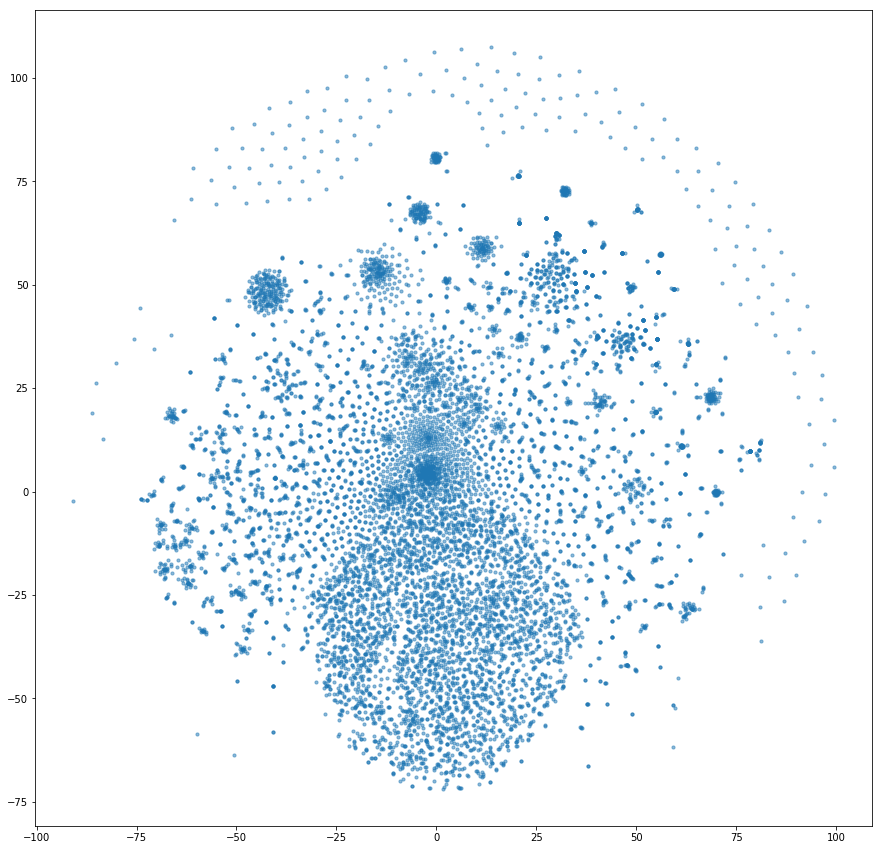

In [11]:
walk_tsne = TSNE(random_state=42, perplexity=30, n_components=2)
X_walk_tsne = walk_tsne.fit_transform(walk_embeddings)
    
plt.figure(figsize=(15, 15))
plt.scatter(X_walk_tsne[:, 0], X_walk_tsne[:, 1], s=10, alpha=0.5)
plt.show()

# Application 2: Find nearest neighbors of paper in embedding space

We can get the nearest neighbors of a paper in the embedded space to find similar papers

In [12]:
np.random.seed(42)
rand_paper_ix = np.random.choice(range(len(papers)))
rand_embedding = walk_embeddings[rand_paper_ix]
rand_paper = papers[rand_paper_ix]
cosine_sims = cosine_similarity([rand_embedding], walk_embeddings)[0]
top_matches = np.argsort(cosine_sims)[-10:-1]
top_papers = []
for ix in top_matches:
    top_papers.append(papers[ix].replace('/doi.org%2F', '/'))
print('Closest neighbors of {}:\n'.format(rand_paper))
print('\t' + '\n\t'.join(top_papers))

Closest neighbors of http://dx.doi.org/10.1101%2F852558:

	http://dx.doi.org/10.3390%2Fv4020236
	http://dx.doi.org/10.1186%2Fs12917-014-0213-8
	http://dx.doi.org/10.1038%2Fs41598-017-13732-2
	http://dx.doi.org/10.1080%2F21645515.2018.1526553
	http://dx.doi.org/10.2147%2FIDR.S213296
	http://dx.doi.org/10.1186%2F1472-6882-13-139
	http://dx.doi.org/10.1101%2F346411
	http://dx.doi.org/10.1183%2F23120541.00015-2015
	http://dx.doi.org/10.1186%2Fs12890-016-0320-3


# Application 3: Clustering the embeddings

We can automatically cluster the embeddings. Here, I just demonstrate the clustering with k-Means. An algorithm that can deal with custom distance metrics and automatic decision of number of clusters would probably be more ideal. I have played around with DBScan and OPTICS, but they results were poor + they were slow. I also did not really play around with the number of clusters.

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15)
kmeans.fit(walk_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

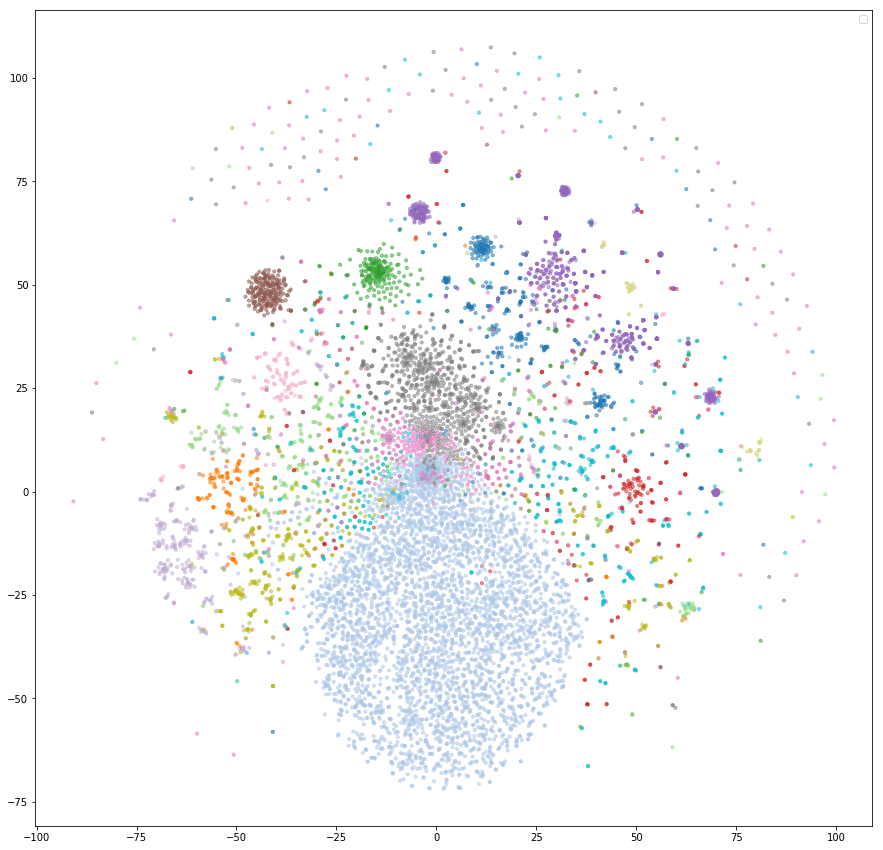

In [14]:
cmap = plt.get_cmap('tab20')
plt.figure(figsize=(15, 15))
plt.scatter(X_walk_tsne[:, 0], X_walk_tsne[:, 1], color=[cmap(x/15) for x in kmeans.labels_], s=10, alpha=0.5)
plt.legend()
plt.show()

# Application 4: Explaining clusters with MINDWALC

Let's take one of the smaller clusters that we could visually identify in our t-SNE plot and see what distinguishes them from other papers. For this, we shall use MINDWALC ([paper](https://biblio.ugent.be/publication/8628802/file/8628803)|[code](https://github.com/IBCNServices/MINDWALC)). We will mine for (depth, vertex) combinations that maximize the information gain.

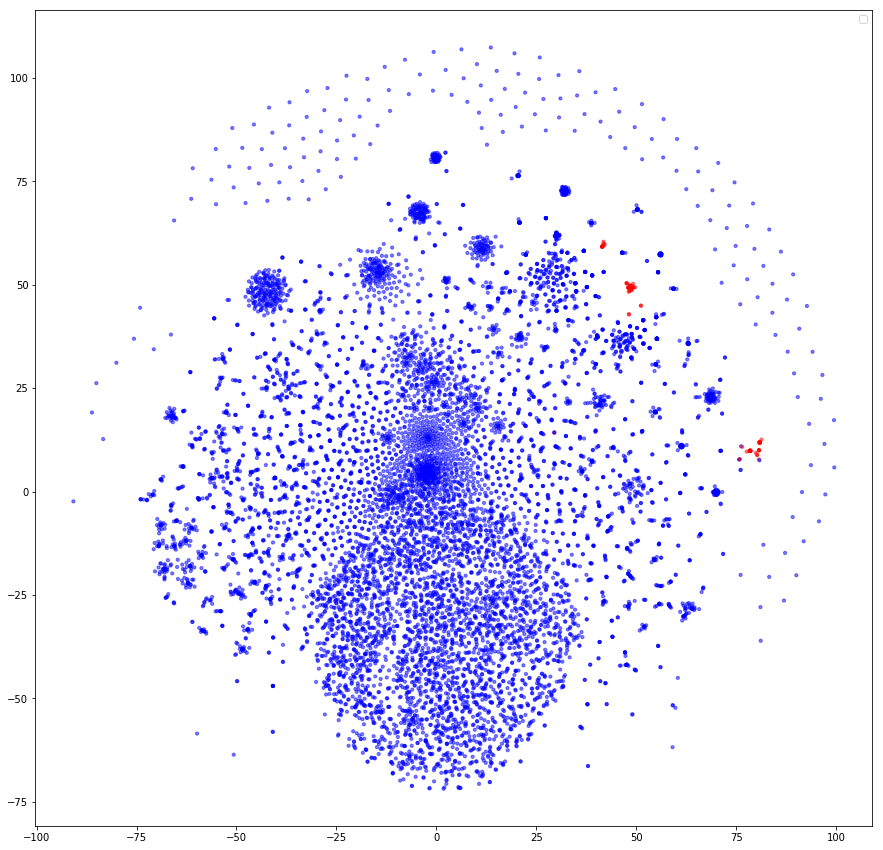

In [15]:
cluster_ix = np.where(kmeans.labels_ == sorted(Counter(kmeans.labels_).items(), key=lambda x: x[1])[0][0])[0]

plt.figure(figsize=(15, 15))
plt.scatter(X_walk_tsne[:, 0], X_walk_tsne[:, 1], color=['r' if i in cluster_ix else 'b' for i in range(len(X_walk_tsne))], s=10, alpha=0.5)
plt.legend()
plt.show()

In [16]:
# This datastructure is different from the one we used for RDF2Vec
kg = Graph.rdflib_to_graph(g)

In [17]:
del g

In [18]:
pos_papers = [papers[ix] for ix in cluster_ix]
neg_papers = [papers[ix] for ix in np.random.choice(list(set(range(len(papers))) - set(cluster_ix)), size=1000, replace=False)]

train_entities = pos_papers + neg_papers
train_labels = [1]*len(pos_papers) + [0]*len(neg_papers)

In [19]:
print(pos_papers[:10])

['http://dx.doi.org/10.1186%2Fs13059-014-0529-5', 'http://dx.doi.org/10.1016%2Fj.jaci.2006.09.021', 'http://dx.doi.org/10.15252%2Fembr.201541678', 'http://dx.doi.org/10.1186%2Fgb-2007-8-5-r93', 'http://dx.doi.org/10.1016%2Fj.physa.2016.07.022', 'http://dx.doi.org/10.1067%2Fmai.2003.94', 'http://dx.doi.org/10.1016%2F0091-6749%2892%2990219-R', 'http://dx.doi.org/10.1111%2Fbjh.16597', 'http://dx.doi.org/10.1111%2Fbjh.16620', 'http://dx.doi.org/10.1016%2Fj.jaci.2012.10.033']


In [20]:
transf = MINDWALCTransform(path_max_depth=8, n_features=100, progress=tqdm_notebook, n_jobs=1)
transf.fit(kg, train_entities, train_labels)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:363: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



279453 279453
[((0.10417816795432605, -6), ('http://overheid.nl/english/', 6)), ((0.10417816795432605, -6), ('http://pl.dbpedia.org/resource/Holandia', 6)), ((0.10417816795432605, -6), ('http://www.bbc.co.uk/news/world-europe-17740800', 6)), ((0.10417816795432605, -6), ('http://rdf.freebase.com/ns/m.04jpfwy', 6)), ((0.10417816795432605, -6), ('http://pt.dbpedia.org/resource/Países_Baixos', 6)), ((0.10417816795432605, -6), ('http://www.iamexpat.nl/expat-page/the-netherlands/general-information', 6)), ((0.10417816795432605, -6), ('http://www.holland.com/', 6)), ((0.10417816795432605, -6), ('http://sw.cyc.com/concept/Mx4rvViJyZwpEbGdrcN5Y29ycA', 6)), ((0.10417816795432605, -6), ('http://www.questia.com/read/85882918/benelux-an-economic-geography-of-belgium-the-netherlands', 6)), ((0.10417816795432605, -6), ('http://rdf.freebase.com/ns/m.059j2', 6)), ((0.10417816795432605, -6), ('http://rdfdata.eionet.europa.eu/ramon/nuts/NL', 6)), ((0.10417816795432605, -6), ('Нидерла́нды (нидерл. Nederl

In [21]:
transf.walks_

{('&#8203;', 6),
 ('0', 6),
 ('0.7', 6),
 ('2.3', 6),
 ('2014', 6),
 ('2016', 6),
 ('250', 6),
 ('53', 6),
 ('77', 6),
 ('79.8', 6),
 ('Monarch', 6),
 ('N', 6),
 ('Prime Minister', 6),
 ('dd-mm-yyyy', 6),
 ('http://dbpedia.org/class/yago/AdministrativeDistrict108491826', 6),
 ('http://dbpedia.org/class/yago/Country108544813', 6),
 ('http://dbpedia.org/class/yago/District108552138', 6),
 ('http://dbpedia.org/class/yago/Location100027167', 6),
 ('http://dbpedia.org/class/yago/Object100002684', 6),
 ('http://dbpedia.org/class/yago/PhysicalEntity100001930', 6),
 ('http://dbpedia.org/class/yago/Region108630985', 6),
 ('http://dbpedia.org/class/yago/WikicatCountries', 6),
 ('http://dbpedia.org/class/yago/WikicatCountriesInEurope', 6),
 ('http://dbpedia.org/class/yago/WikicatGermanicCountriesAndTerritories', 6),
 ('http://dbpedia.org/class/yago/WikicatMemberStatesOfNATO', 6),
 ('http://dbpedia.org/class/yago/WikicatMemberStatesOfTheEuropeanUnion', 6),
 ('http://dbpedia.org/class/yago/WikicatM

# Other applications

There is a lot of other possibilities now that we have our data in a Knowledge Graph:
* We can create embeddings of all our entities: journals, authors, ...
* We can extend our knowledge graph with more knowledge (this will sometimes be needed to create som eof the embeddings, such as inverse relations from the authors to the papers)
* We can solve classification problems
* ...